# Memory Based Classification with KDM

A memory based classifier with  [Kernel Density Matrices](https://github.com/fagonzalezo/kdm).

In [349]:
'''
Create a 2 moons dataset 
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_87156/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


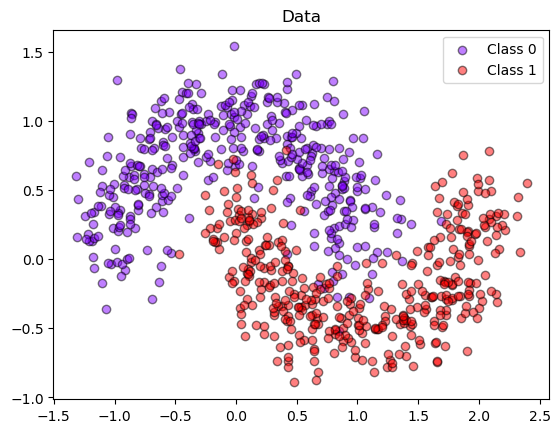

In [350]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun_mem(clf):
    def pred_fun(X):
        X_ds = clf.create_predict_ds(X)
        return clf.predict(X_ds)[:, 1]
    return pred_fun

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

plot_data(X_train, y_train)

In [351]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics

import kdm


## Memory KDM Model

First we pretrain a KDM Model for a few epochs and use the learned encoder for a Memory Based KDM Classifier.

In [352]:
from kdm.models import MemftKdmClassWrapper, KDMClassModel


encoded_size = 10
dim_y = 2
encoder = keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=(2,)),
    keras.layers.Dense(encoded_size, activation='linear', input_shape=(2,)),
])  
n_comp = 20

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=1.)

kdm_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_model.init_components(X_train[idx], 
                          np.eye(2)[y_train[idx]],
                          init_sigma=True)
print(f"Initial sigma: {kdm_model.kernel.sigma.numpy()}")
#kdm_model.fit(X_train, y_train, epochs=2, batch_size=32)
print(f"FInal sigma: {kdm_model.kernel.sigma.numpy()}")


Initial sigma: 0.848763108253479
FInal sigma: 0.848763108253479


/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/keras_core/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We evaluate the performance of the classifier on the test set.

In [353]:
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = kdm_model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Test loss: 0.44309481978416443
Test accuracy: 0.8399999737739563
Train loss: 0.4671748876571655
Train accuracy: 0.8237500190734863


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step    
0.047329772 0.047329772


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_87156/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


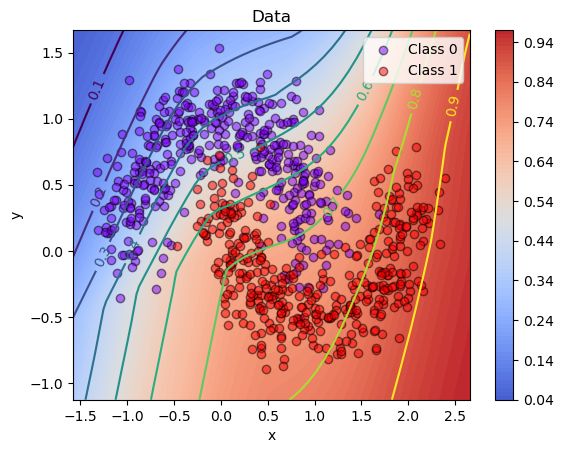

In [354]:
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)


Since the model is trained for few epochs, the performance is not very good. Now we use the same encoder with a Memory Based KDM Classifier.

In [355]:
encoded_size = 10
dim_y = 2
n_comp = 30

mkdm_model = MemftKdmClassWrapper(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            samples_x=X_train,
                            samples_y=np.eye(2)[y_train],
                            sigma=kdm_model.kernel.sigma.numpy())


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step        


Sigma: 0.848763108253479
Test accuracy: 0.965
0.0 0.0


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_87156/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


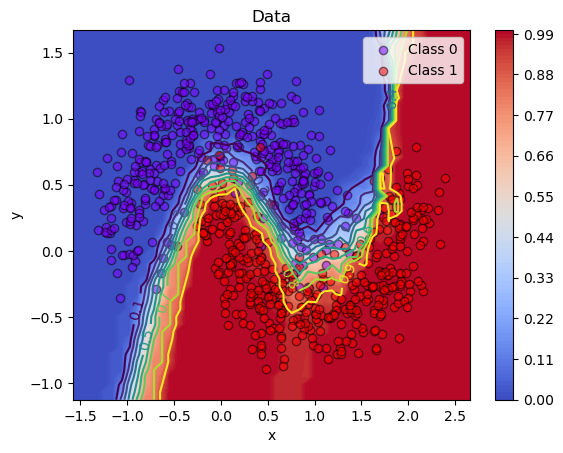

In [356]:
from sklearn.metrics import accuracy_score

print(f'Sigma: {mkdm_model.model.kernel.sigma.numpy()}')
pred_y = mkdm_model.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
print("Test accuracy: {}".format(accuracy_score(y_test, pred_y)))

plot_decision_region(X, gen_pred_fun(mkdm_model))
plot_data(X_train, y_train)


In [357]:
optimizer = optimizers.Adam(learning_rate=1e-4)
optimizer = optimizers.SGD(learning_rate=1e-4)
mkdm_model.fit(epochs=100, batch_size=32, recalc_index_every=10)

0 0.3736703503131866
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step        
1 0.36716721296310423
2 0.38932764053344726
3 0.41881718635559084
4 0.4282068860530853
5 0.4480293500423431
6 0.4799783504009247
7 0.5176289319992066
8 0.5321839582920075
9 0.4714667344093323
10 0.43890983462333677
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step        
11 0.36294347167015073
12 0.36289002299308776
13 0.3631503653526306
14 0.3645514154434204
15 0.3646194660663605
16 0.36556517601013183
17 0.3660329186916351
18 0.3665786921977997
19 0.3676450204849243
20 0.36792762637138365
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step        
21 0.36260889291763304
22 0.36254791617393495
23 0.362591073513031
24 0.36248555302619934
25 0.36258481979370116
26 0.36282025337219237
27 0.3626121926307678
28 0.36254520416259767
29 0.362486743927002
30 0.3625570464134216
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step        
31 0.3623807990550995
32 0.36246535301208493
33 0.3625600504875183
34 0.36234223961830136
35 0.3624220645427704
36 0.362

<MemFTKDMClassModel name=mem_ftkdm_class_model_36, built=True>

Sigma: 0.8288034796714783
Test accuracy: 0.97
0.0 0.0


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_87156/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


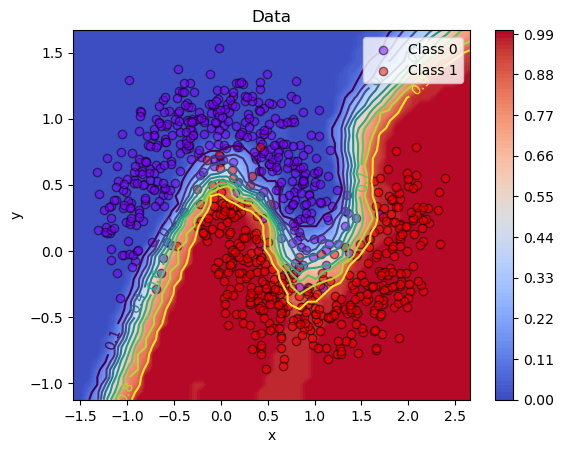

In [358]:

print(f'Sigma: {mkdm_model.model.kernel.sigma.numpy()}')

pred_y = mkdm_model.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
print("Test accuracy: {}".format(accuracy_score(y_test, pred_y)))

plot_decision_region(X, gen_pred_fun(mkdm_model))
plot_data(X_train, y_train)


The performance is much better. We can fine tune the sigma parameter.

## MNIST example

An example using the mnist dataset. In addition to perform classification we will show how to perform generation.

In [359]:
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics
import kdm

from importlib import reload


In [382]:
# Create a dataset from mnist using tf
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


# reshape the data to include a channel dimension
X_train_full = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))
X_train_filtered = X_train_full[(y_train >= 0) & (y_train <= 4)]
y_train_filtered = y_train[(y_train >= 0) & (y_train <= 4)]
y_train_full = y_train
# Partition the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                  test_size=0.2, random_state=42)

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
      x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
      fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
      axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
      axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()


We define a deep encoder that will be used to map input images to a low-dimensional latent space.

In [383]:
tfkl = keras.layers

def create_encoder(img_shape, base_depth, encoded_size):
    input_shape = (np.prod(img_shape),)
    encoder = keras.Sequential([
        tfkl.InputLayer(shape=(input_shape)),
        tfkl.Reshape(img_shape),
        tfkl.Lambda(lambda x: x - 0.5),
        tfkl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=keras.ops.leaky_relu),
        tfkl.Dense(encoded_size,
                activation=None),#, activity_regularizer=tf.keras.regularizers.l2(1e-3)),
        #tfkl.layers.LayerNormalization(),
        tfkl.Flatten(),
    ])
    return encoder

The classifier model (QKMClassModel) receives as input the encoder, and applies it before applying the QKM inference layer.

In [384]:
# Define the encoder
img_shape = (28, 28, 1)
base_depth = 32
encoded_size = 16
encoder1 = create_encoder(img_shape, base_depth, encoded_size)

# warm up the encoder
enc_model = keras.Sequential([encoder1,
                keras.layers.Dense(10, activation='softmax')])
enc_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                loss=losses.sparse_categorical_crossentropy,
                metrics=[metrics.sparse_categorical_accuracy])
enc_model.fit(X_train, y_train, epochs=1, batch_size=128)

score = enc_model.evaluate(X_test, y_test, verbose=0)
print('Base encoder test loss:', score[0])
print('Base encoder test accuracy:', score[1])
score = enc_model.evaluate(X_train, y_train, verbose=0)
print('Base encoder train loss:', score[0])
print('Base encoder train accuracy:', score[1])


# Create a classifier model
dim_y = 10
n_comp = 64

kdm_mnist = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder1,
                            n_comp=n_comp,        
                            sigma=0.1)

# initialize the prototypes using random samples from the training set
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_mnist.init_components(X_train[idx], keras.ops.one_hot(y_train[idx], 10), 
                          init_sigma=True, sigma_mult=0.1)

print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

# Compile the model
kdm_mnist.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

# Evaluate the classifier
score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
print('KDM test loss:', score[0])
print('KDM test accuracy:', score[1])
score = kdm_mnist.evaluate(X_train, y_train, verbose=0)
print('KDM train loss:', score[0])
print('KDM train accuracy:', score[1])
print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

375/375 ━━━━━━━━━━━━━━━━━━━━ 47681s 127s/step - loss: 0.7191 - sparse_categorical_accuracy: 0.7421
Base encoder test loss: 0.3966735601425171
Base encoder test accuracy: 0.857699990272522
Base encoder train loss: 0.35978323221206665
Base encoder train accuracy: 0.8699791431427002
Sigma: 1.5283176898956299
KDM test loss: 1.4572772979736328
KDM test accuracy: 0.6055999994277954
KDM train loss: 1.4169169664382935
KDM train accuracy: 0.6124374866485596
Sigma: 1.5283176898956299


In [385]:
# create callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
earlystop = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                           verbose=1, restore_best_weights=True)

# Train the model
kdm_mnist.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs=1, batch_size=128, verbose=1,
              callbacks=[earlystop])
print(f'Final Sigma: {kdm_mnist.kernel.sigma.numpy()}')


375/375 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - loss: 0.6726 - sparse_categorical_accuracy: 0.7956 - val_loss: 0.4336 - val_sparse_categorical_accuracy: 0.8670
Final Sigma: 1.72493577003479


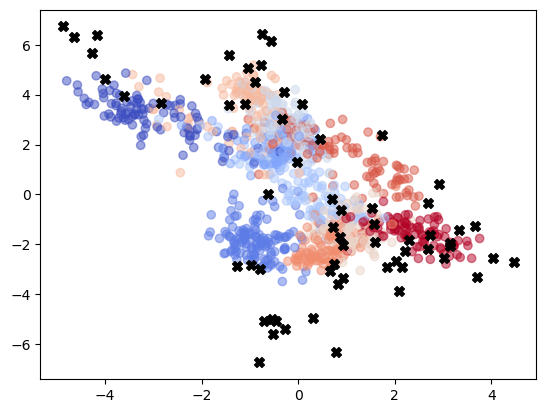

In [386]:
import matplotlib.pyplot as plt
# Visualize the points in the feature space
X_train_sample = keras.ops.convert_to_numpy(encoder1(X_train[:1000]))
plt.scatter(X_train_sample[:, 0], X_train_sample[:, 1], alpha=0.5, c=y_train[:1000], cmap=plt.cm.coolwarm)

# plot the prototypes
plt.scatter(kdm_mnist.kdm.c_x.numpy()[:, 0], kdm_mnist.kdm.c_x.numpy()[:, 1], c='k', marker='X', s=50)
plt.show()

The figure above show training samples mapped to the latent space with different colors according to the class. The prototypes are shown as black crosses. Note that the prototypes do not cover all the areas of the different classes in the latent space, rather they are positioned to maximize the classification performance.

In [387]:
# Evaluate the classifier
score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
print('KDM Test loss:', score[0])
print('KDM Test accuracy:', score[1])
score = kdm_mnist.evaluate(X_train, y_train, verbose=0)
print('KDM Train loss:', score[0])
print('KDM Train accuracy:', score[1])
print(f'KDM Sigma: {kdm_mnist.kernel.sigma.numpy()}')

KDM Test loss: 0.44994819164276123
KDM Test accuracy: 0.8651000261306763
KDM Train loss: 0.3985249400138855
KDM Train accuracy: 0.8766458630561829
KDM Sigma: 1.72493577003479


Now we will train a density estimation model using the QKMJointDenEstModel class and keeping the encoder fix. This model maximizes the joint likelihood of inputs and outputs. The goal is to obtain more representative prototypes, since the prototypes learned using the classification model are not representative of the data distribution, since them are optimized to maximize the classification accuracy.

In [388]:
n_comp = 30

encoder2 = create_encoder(img_shape, base_depth, encoded_size)
encoder2.set_weights(encoder1.get_weights())


mkdm_model = MemftKdmClassWrapper(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder2,
                            n_comp=n_comp,
                            samples_x=X_train_full,
                            samples_y=np.eye(10)[y_train_full],
                            sigma=kdm_model.kernel.sigma.numpy())


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 123s 66ms/step


In [376]:
X_test.shape
encoder2(X_test).shape

torch.Size([10000, 16])

In [390]:
print(f'Sigma: {mkdm_model.model.kernel.sigma.numpy()}')
pred_y = mkdm_model.predict(X_test, batch_size=256)
pred_y = np.argmax(pred_y, axis=1)
print("Test accuracy: {}".format(accuracy_score(y_test, pred_y)))


Sigma: 0.848763108253479
Test accuracy: 0.8857


In [367]:
from kdm.models import MemKDMClassModel
n_comp = 300
encoder2 = create_encoder(input_shape, base_depth, encoded_size)
encoder2.set_weights(encoder1.get_weights())

mkdm_model = MemKDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder2,
                            n_comp=n_comp,
                            sigma=kdm_mnist.kernel.sigma.numpy())

# init the memory
mkdm_model.create_index(X_train, np.eye(10)[y_train])
X_train_ds = mkdm_model.create_train_ds(batch_size=32)
X_test_ds = mkdm_model.create_test_ds(X_test, np.eye(10)[y_test], batch_size=32)
X_pred_ds = mkdm_model.create_predict_ds(X_test)

mkdm_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])

750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step


NotImplementedError: in user code:

    File "/Users/fgonza/Documents/research/code/kdm/kdm/models/mem_kdm_class_model.py", line 77, in tf_search  *
        x_enc = self.encoder(x)
    File "/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/keras_core/src/utils/traceback_utils.py", line 629, in error_handler  *
        return fn(*args, **kwargs)
    File "/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/keras_core/src/layers/layer.py", line 650, in maybe_convert  *
        return backend.convert_to_tensor(x, dtype=self.input_dtype)
    File "/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/tree/__init__.py", line 434, in map_structure  *
        return unflatten_as(structures[0],
    File "/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/keras_core/src/backend/torch/core.py", line 140, in convert_to_tensor  *
        x = np.array(x)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (args_0:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [23]:
scores = []
mult = [2 ** i for i in range(-3, 7, 1)]
for m in mult:
    mkdm_model.kernel.sigma.assign(kdm_mnist.kernel.sigma.numpy() * m)
    score = mkdm_model.evaluate(X_test_ds, verbose=0)
    print(mkdm_model.kernel.sigma.numpy())
    print('Mem QKM Test loss:', score[0])
    print('Mem QKM Test accuracy:', score[1])
    scores.append(score)


0.23567207
Mem QKM Test loss: 0.35181793570518494
Mem QKM Test accuracy: 0.8732972741127014
0.47134414
Mem QKM Test loss: 0.35181793570518494
Mem QKM Test accuracy: 0.8732972741127014
0.9426883
Mem QKM Test loss: 0.35181793570518494
Mem QKM Test accuracy: 0.8732972741127014
1.8853766
Mem QKM Test loss: 0.35181793570518494
Mem QKM Test accuracy: 0.8732972741127014
3.7707531
Mem QKM Test loss: 0.352114200592041
Mem QKM Test accuracy: 0.8731971383094788
7.5415063
Mem QKM Test loss: 0.35227712988853455
Mem QKM Test accuracy: 0.8729968070983887
15.083013
Mem QKM Test loss: 0.3536068797111511
Mem QKM Test accuracy: 0.8727964758872986
30.166025
Mem QKM Test loss: 0.35968613624572754
Mem QKM Test accuracy: 0.8697916865348816
60.33205
Mem QKM Test loss: 0.35434287786483765
Mem QKM Test accuracy: 0.8729968070983887
120.6641
Mem QKM Test loss: 0.35201534628868103
Mem QKM Test accuracy: 0.8731971383094788


In [27]:
import tensorflow as tf
X_pred_ds[0].shape, X_pred_ds[1].shape
neigh_x =  tf.gather(mkdm_model.samples_x, X_pred_ds[1], axis=0)
# Calculate the distance between the query and the neighbors
dist = tf.norm(X_pred_ds[0][:, tf.newaxis, :] - neigh_x, axis=2)
# Calculate the average, min and max distance
avg_dist = tf.reduce_mean(dist, axis=1)
min_dist = tf.reduce_min(dist, axis=1)
max_dist = tf.reduce_max(dist, axis=1)
# plot a histogram of the distances


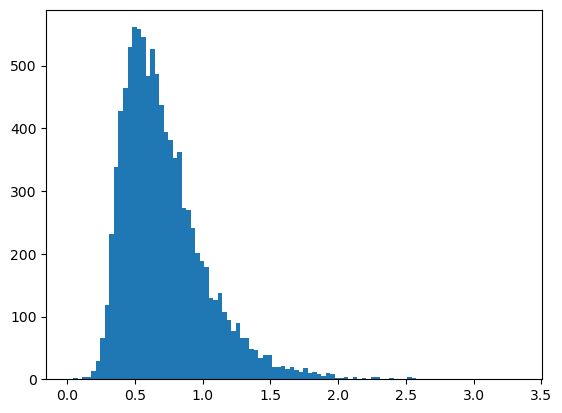

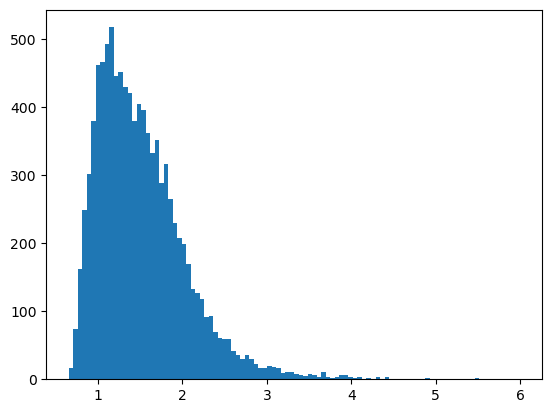

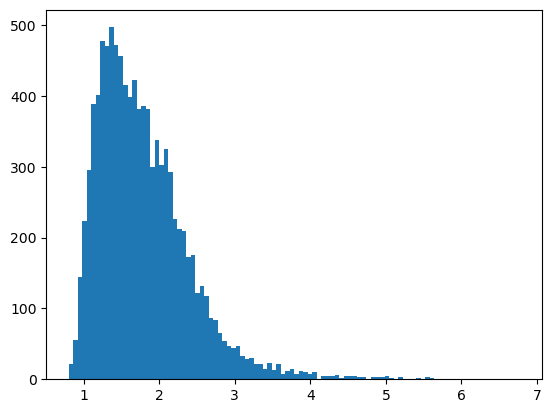

In [28]:
import matplotlib.pyplot as plt
plt.hist(min_dist.numpy(), bins=100)
plt.show()

plt.hist(avg_dist.numpy(), bins=100)
plt.show()

plt.hist(max_dist.numpy(), bins=100)
plt.show()


In [30]:

mkdm_model.kernel.sigma.assign(5)
mkdm_model.predict((X_pred_ds[0][0:2], X_pred_ds[1][0:2]) ,  verbose=0)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01      , 0.        , 0.9900001 ],
       [0.        , 0.        , 0.9566668 , 0.        , 0.01      ,
        0.        , 0.03333334, 0.        , 0.        , 0.        ]],
      dtype=float32)

In [31]:
X_pred_ds[0].shape, X_pred_ds[1].shape

(TensorShape([10000, 16]), TensorShape([10000, 300]))

In [32]:
from kdm.layers import MemRBFKernelLayer, MemQKMLayer, RBFKernelLayer


mrbfk = MemRBFKernelLayer(sigma=0.5, dim=64)
rbfk = RBFKernelLayer(sigma=0.5, dim=64)
mqkm = MemQKMLayer(kernel=mrbfk, dim_x=64, dim_y=1, n_comp=200)

x_enc, neighbors = X_pred_ds[0][:20], X_pred_ds[1][:20]
x_neigh = tf.gather(mqkm_model.samples_x, neighbors, axis=0)
y_neigh = tf.gather(mqkm_model.samples_y, neighbors, axis=0)
rho_y = mqkm([x_enc, x_neigh, y_neigh])
print(rho_y[0, :10, 0])

ModuleNotFoundError: No module named 'qkm'

In [19]:
in_v = tf.expand_dims(x_enc, axis=1) # shape (bs, 1, dim_x)
out_vw = mrbfk(in_v, x_neigh)
out_vw_1 = rbfk(in_v, x_neigh[0])
print (out_vw.shape)
print(out_vw[0,0,:10] ** 2)
print(out_vw_1[0,0,:10] ** 2)

(20, 1, 300)
tf.Tensor(
[0.45210585 0.42390808 0.3779821  0.33470502 0.28690717 0.2431942
 0.21471964 0.1803271  0.17919157 0.1788815 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.45210585 0.42391136 0.3779821  0.33470502 0.28690502 0.24319604
 0.214718   0.1803285  0.17918883 0.17888285], shape=(10,), dtype=float32)


In [20]:
np.sum(y_neigh,axis=1)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 300.],
       [  0.,   0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  3.,   0.,   0.,   0.,   0.,   0., 297.,   0.,   0.,   0.],
       [  0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 300.,   0.,   0.],
       [  0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 213.,   0.,  84.,   3.,   0.],
       [  0.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  85.,   0., 21

In [21]:
print(y_neigh[8, :10])

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)


In [53]:
qkm_mnist.kernel.sigma.assign(5)
qkm_mnist.predict(X_test[:2], verbose=0)

array([[1.14879615e-04, 5.51695994e-05, 7.83121504e-05, 6.73886680e-05,
        6.80981902e-05, 7.99595437e-05, 1.33094436e-04, 9.99308944e-01,
        4.09124877e-05, 5.33210768e-05],
       [6.11804790e-05, 2.23394691e-05, 9.99747813e-01, 1.04540923e-05,
        5.60874978e-05, 5.71921191e-06, 4.64761761e-05, 2.53393737e-05,
        2.52210566e-06, 2.21634091e-05]], dtype=float32)

In [33]:
# train the classifier
mkdm_model.kernel.sigma.assign(kdm_mnist.kernel.sigma.numpy())
mkdm_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
print(f"Initial sigma: {mkdm_model.kernel.sigma.numpy()}")
mkdm_model.fit(X_train_ds, epochs=2, verbose=1)
print(f"FInal sigma: {mkdm_model.kernel.sigma.numpy()}")


Initial sigma: 1.8853765726089478
Epoch 1/2


/Users/fgonza/miniforge3/envs/tf2/lib/python3.11/site-packages/keras_core/src/optimizers/base_optimizer.py:412: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - categorical_accuracy: 0.8894 - loss: 0.3088
Epoch 2/2
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - categorical_accuracy: 0.8894 - loss: 0.3088
FInal sigma: 1.8853765726089478


In [34]:
score = mkdm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Test loss: 0.35181793570518494
Test accuracy: 0.8732972741127014


In [34]:
encoder2.set_weights(encoder1.get_weights())


In [34]:
neighbors =  X_pred_ds[1]
y_neigh = tf.gather(mqkm_model.samples_y, neighbors, axis=0)
y_pred = np.argmax(y_neigh, axis=1)
y_neigh.shape

TensorShape([10000, 300, 10])

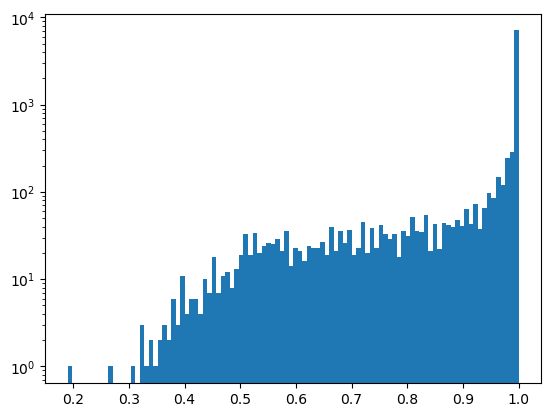

In [29]:
y_avg = np.mean(y_neigh, axis=1)
plt.hist(np.max(y_avg, axis=1), bins=100, log=True);

In [35]:
from sklearn.metrics import accuracy_score  
y_pred = np.argmax(y_avg, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.9054
